In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import torch
import os

import sys
sys.path.insert(0, '../trainingdata')
from datasaver import *
sys.path.insert(0, '../testproblems/tdarcy')
from manufacturedsolutions import *
sys.path.insert(0, '../ml')
from modelloader import loadmodelfromlabel
from NeuralOperator import NeuralOperator
from customlosses import *
from quadrature import *
from customlayers import discretize_functions
from basisfunctions import *

In [3]:
%load_ext autoreload
%autoreload 2

In [33]:
n_timesteps = 1
Dt = 1/n_timesteps

from NeuralOperator import NeuralOperator

logdir = '../../../nnlogs'
device = 'cuda:3'

sublogdir = 'massconservation'

projection = loadmodelfromlabel(model=NeuralOperator, label='modelNGO_4x10x10', logdir=logdir, sublogdir=sublogdir, device=device)
projection.hparams['modeltype'] = 'projection'
projection.hparams['dtype'] = torch.float64
projection.hparams['discretization_device'] = device
projection.hparams['n_timesteps'] = n_timesteps
projection.hparams['Dt'] = Dt
projection.hparams['output_coefficients'] = True
projection.__init__(projection.hparams)

FEM = loadmodelfromlabel(model=NeuralOperator, label='modelNGO_4x10x10', logdir=logdir, sublogdir=sublogdir, device=device)
FEM.hparams['modeltype'] = 'FEM'
FEM.hparams['dtype'] = torch.float64
FEM.hparams['discretization_device'] = device
FEM.hparams['n_timesteps'] = n_timesteps
FEM.hparams['Dt'] = Dt
FEM.hparams['output_coefficients'] = True
FEM.__init__(FEM.hparams)

modelNGO = loadmodelfromlabel(model=NeuralOperator, label='modelNGO_4x10x10', logdir=logdir, sublogdir=sublogdir, device=device)
modelNGO.hparams['discretization_device'] = device
modelNGO.hparams['n_timesteps'] = n_timesteps
modelNGO.hparams['Dt'] = Dt
modelNGO.hparams['output_coefficients'] = True
modelNGO.__init__(modelNGO.hparams)

modelNGO_C = loadmodelfromlabel(model=NeuralOperator, label='modelNGO_C_4x10x10', logdir=logdir, sublogdir=sublogdir, device=device)
modelNGO_C.hparams['discretization_device'] = device
modelNGO_C.hparams['n_timesteps'] = n_timesteps
modelNGO_C.hparams['Dt'] = Dt
modelNGO_C.hparams['output_coefficients'] = True
modelNGO_C.__init__(modelNGO_C.hparams)


modeldict = {'Projection': projection,
             'FEM': FEM,
             #'NN': NN,
             #'DeepONet': DeepONet,
             #'VarMiON': VarMiON,
            #'Data NGO': dataNGO,
            #'Data-free NGO': datafreeNGO,
            'Model NGO': modelNGO,
            'm-conserving model NGO': modelNGO_C}

In [15]:
N_samples = 100

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

t_values = np.linspace(0,1,11)
quadrature = GaussLegendreQuadrature(n_elements=[1,3,3], Q=[1,99,99])
x = quadrature.xi
w = quadrature.w
# l = np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
l = np.array([1])

L2_scaled_avg = np.zeros((len(modeldict),len(t_values)))
yerr = np.zeros((len(modeldict),2,len(t_values)))

size_title = 20
size_ticklabels = 15
size_axeslabels = 20

linestyles=['-','-','--','--','--','--','--','--','--','--']
colors = ['black','grey','C0','C2','C3','C4']
    
for i in range(len(t_values)):
    print(t_values[i])
    dataset = ManufacturedSolutionsSet(N_samples=N_samples, variables=['t','x','x'], l_min=[0.5,0.5,0.5], l_max=[1,1,1], device=device)
    theta = dataset.theta
    f = dataset.f
    etat = dataset.etat
    etab = dataset.etab
    gl = dataset.gl
    gr = dataset.gr
    u = dataset.u
    u0 = dataset.u0
    m=0
    for model in modeldict:
        print(str(model))
        x[:,0] = t_values[i]
        u_exact = discretize_functions(u, x, dtype=modeldict[str(model)].hparams['dtype'], device=device)
        u_hat = modeldict[str(model)].simforward(theta, f, etab, etat, gl, gr, u0, x, u)
        print(f"Memory allocated: {torch.cuda.memory_allocated(device) / 1024 ** 2:.2f} MB")
        print(f"Memory reserved: {torch.cuda.memory_reserved(device) / 1024 ** 2:.2f} MB")
        L2_scaled_array = weightedrelativeL2_set(w, u_hat, u_exact)
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])
        m+=1

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
plots.append(ax.axvspan(0.5,1, color='black', alpha=0.1, label='Training data range'))
m=0
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'Time $t/T$', fontsize=size_axeslabels)
ax.set_ylabel(r'Rel. L2 error $\frac{||\hat{u}(t)-u(t)||_2}{||u(t)||_2}$', fontsize=size_axeslabels)
ax.set_yscale('log')
ax.set_xlim(0, 1.05)
ax.grid()
# ax.set_title('FNO', fontsize=size_title)
for model in modeldict:
    plots.append(ax.errorbar(t_values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))
    m+=1
plt.legend(fontsize=10, ncols=1)
# legend1 = ax.legend(handles=plots[0:2],fontsize=10, ncols=1, loc='lower left')
# plt.gca().add_artist(legend1)
# legend2 = ax.legend(handles=plots[2:],fontsize=10, ncols=2, loc='upper right')
# plt.gca().add_artist(legend2)

# plt.savefig("FNO.pdf", bbox_inches='tight')#, transparent=True)
# plt.savefig("lengthscales.svg", bbox_inches='tight')#, transparent=True)
# plt.savefig("lengthscales.pdf", bbox_inches='tight')#, transparent=True)

plt.show()

0.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Projection
0
1
2
3
4
5
6
7
8
9
Memory allocated: 23.95 MB
Memory reserved: 276.00 MB
FEM
0
1
2
3
4
5
6
7
8
9
Memory allocated: 24.84 MB
Memory reserved: 648.00 MB
Model NGO
0
1
2
3
4
5
6
7
8
9
Memory allocated: 24.84 MB
Memory reserved: 934.00 MB
m-conserving model NGO
0
1
2
3
4
5
6
7
8
9
Memory allocated: 24.84 MB
Memory reserved: 934.00 MB
0.1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Projection
0
1
2
3
4
5
6
7
8
9
Memory allocated: 24.84 MB
Memory res

KeyboardInterrupt: 

0.0
0
Projection
0
Memory allocated: 19.88 MB
Memory reserved: 34.00 MB
FEM
0
Memory allocated: 19.88 MB
Memory reserved: 54.00 MB
Model NGO
0
Memory allocated: 19.88 MB
Memory reserved: 38.00 MB
m-conserving model NGO
0
Memory allocated: 19.88 MB
Memory reserved: 38.00 MB
0.5
0
Projection
0
Memory allocated: 19.88 MB
Memory reserved: 34.00 MB
FEM
0
Memory allocated: 19.88 MB
Memory reserved: 54.00 MB
Model NGO
0
Memory allocated: 19.88 MB
Memory reserved: 38.00 MB
m-conserving model NGO
0
Memory allocated: 19.88 MB
Memory reserved: 38.00 MB
1.0
0
Projection
0
Memory allocated: 19.88 MB
Memory reserved: 34.00 MB
FEM
0
Memory allocated: 19.88 MB
Memory reserved: 54.00 MB
Model NGO
0
Memory allocated: 19.88 MB
Memory reserved: 38.00 MB
m-conserving model NGO
0
Memory allocated: 19.88 MB
Memory reserved: 38.00 MB


/tmp/ipykernel_1812072/448271214.py:63: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(t_values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))


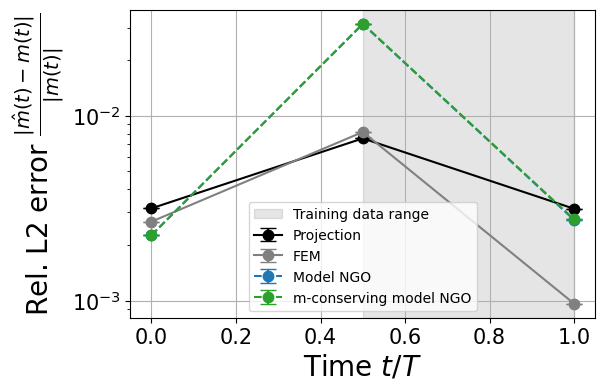

: 

In [ ]:
N_samples = 1

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

t_values = np.linspace(0,1,3)
quadrature = GaussLegendreQuadrature(n_elements=[1,3,3], Q=[1,99,99])
x = quadrature.xi
w = quadrature.w
# l = np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

L2_scaled_avg = np.zeros((len(modeldict),len(t_values)))
yerr = np.zeros((len(modeldict),2,len(t_values)))

size_title = 20
size_ticklabels = 15
size_axeslabels = 20

linestyles=['-','-','--','--','--','--','--','--','--','--']
colors = ['black','grey','C0','C2','C3','C4']
    
for i in range(len(t_values)):
    print(t_values[i])
    dataset = ManufacturedSolutionsSet(N_samples=N_samples, variables=['t','x','x'], l_min=[0.5,0.5,0.5], l_max=[1,1,1], device=device)
    theta = dataset.theta
    f = dataset.f
    etat = dataset.etat
    etab = dataset.etab
    gl = dataset.gl
    gr = dataset.gr
    u = dataset.u
    u0 = dataset.u0
    m=0
    for model in modeldict:
        print(str(model))
        x[:,0] = t_values[i]
        u_exact = discretize_functions(u, x, dtype=modeldict[str(model)].hparams['dtype'], device=device)
        u_hat = modeldict[str(model)].simforward(theta, f, etab, etat, gl, gr, u0, x, u)
        print(f"Memory allocated: {torch.cuda.memory_allocated(device) / 1024 ** 2:.2f} MB")
        print(f"Memory reserved: {torch.cuda.memory_reserved(device) / 1024 ** 2:.2f} MB")
        L2_scaled_array = weightedrelativeL1_set(w, u_hat, u_exact)
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])
        m+=1

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
plots.append(ax.axvspan(0.5,1, color='black', alpha=0.1, label='Training data range'))
m=0
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'Time $t/T$', fontsize=size_axeslabels)
ax.set_ylabel(r'Rel. L2 error $\frac{|\hat{m}(t)-m(t)|}{|m(t)|}$', fontsize=size_axeslabels)
ax.set_yscale('log')
ax.set_xlim(-0.05, 1.05)
ax.grid()
# ax.set_title('FNO', fontsize=size_title)
for model in modeldict:
    plots.append(ax.errorbar(t_values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))
    m+=1
plt.legend(fontsize=10, ncols=1)
# legend1 = ax.legend(handles=plots[0:2],fontsize=10, ncols=1, loc='lower left')
# plt.gca().add_artist(legend1)
# legend2 = ax.legend(handles=plots[2:],fontsize=10, ncols=2, loc='upper right')
# plt.gca().add_artist(legend2)

# plt.savefig("FNO.pdf", bbox_inches='tight')#, transparent=True)
# plt.savefig("lengthscales.svg", bbox_inches='tight')#, transparent=True)
# plt.savefig("lengthscales.pdf", bbox_inches='tight')#, transparent=True)

plt.show()

0.0
0
1
2
3
4
5
6
7
8
9
Projection
0
(10,)
(10,)
(10,)
Memory allocated: 19.90 MB
Memory reserved: 60.00 MB
FEM
0
(10,)
(10,)
(10,)
Memory allocated: 19.90 MB
Memory reserved: 104.00 MB
Model NGO
0
(10,)
(10,)
(10,)
Memory allocated: 19.90 MB
Memory reserved: 134.00 MB
m-conserving model NGO
0
(10,)
(10,)
(10,)
Memory allocated: 19.90 MB
Memory reserved: 134.00 MB
0.5
0
1
2
3
4
5
6
7
8
9
Projection
0
(10,)
(10,)
(10,)
Memory allocated: 19.90 MB
Memory reserved: 60.00 MB
FEM
0
(10,)
(10,)
(10,)
Memory allocated: 19.90 MB
Memory reserved: 104.00 MB
Model NGO
0
(10,)
(10,)
(10,)
Memory allocated: 19.90 MB
Memory reserved: 134.00 MB
m-conserving model NGO
0
(10,)
(10,)
(10,)
Memory allocated: 19.90 MB
Memory reserved: 134.00 MB
1.0
0
1
2
3
4
5
6
7
8
9
Projection
0
(10,)
(10,)
(10,)
Memory allocated: 19.90 MB
Memory reserved: 60.00 MB
FEM
0
(10,)
(10,)
(10,)
Memory allocated: 19.90 MB
Memory reserved: 104.00 MB
Model NGO
0
(10,)
(10,)
(10,)
Memory allocated: 19.90 MB
Memory reserved: 134.00

/tmp/ipykernel_1812072/2306646165.py:63: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(t_values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))


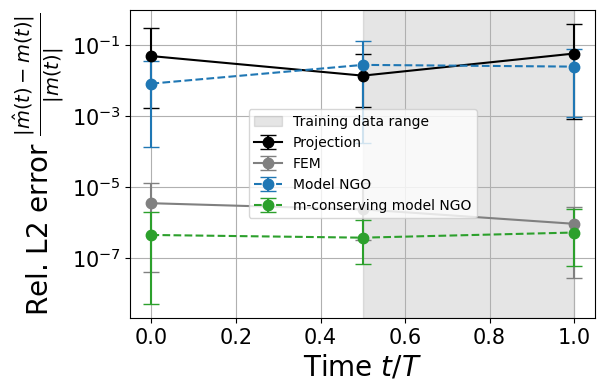

In [ ]:
N_samples = 10

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

t_values = np.linspace(0,1,3)
quadrature = GaussLegendreQuadrature(n_elements=[1,3,3], Q=[1,99,99])
x = quadrature.xi
w = quadrature.w
# l = np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

L2_scaled_avg = np.zeros((len(modeldict),len(t_values)))
yerr = np.zeros((len(modeldict),2,len(t_values)))

size_title = 20
size_ticklabels = 15
size_axeslabels = 20

linestyles=['-','-','--','--','--','--','--','--','--','--']
colors = ['black','grey','C0','C2','C3','C4']
    
for i in range(len(t_values)):
    print(t_values[i])
    dataset = ManufacturedSolutionsSet(N_samples=N_samples, variables=['t','x','x'], l_min=[0.5,0.5,0.5], l_max=[1,1,1], device=device)
    theta = dataset.theta
    f = dataset.f
    etat = dataset.etat
    etab = dataset.etab
    gl = dataset.gl
    gr = dataset.gr
    u = dataset.u
    u0 = dataset.u0
    m=0
    for model in modeldict:
        print(str(model))
        x[:,0] = t_values[i]
        u_exact = discretize_functions(u, x, dtype=modeldict[str(model)].hparams['dtype'], device=device)
        C_error = modeldict[str(model)].simforward_C(theta, f, etab, etat, gl, gr, u0, x, u)
        print(f"Memory allocated: {torch.cuda.memory_allocated(device) / 1024 ** 2:.2f} MB")
        print(f"Memory reserved: {torch.cuda.memory_reserved(device) / 1024 ** 2:.2f} MB")
        L2_scaled_array = C_error
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])
        m+=1

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
plots.append(ax.axvspan(0.5,1, color='black', alpha=0.1, label='Training data range'))
m=0
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'Time $t/T$', fontsize=size_axeslabels)
ax.set_ylabel(r'Rel. L2 error $\frac{|\hat{C}-C|}{|C|}$', fontsize=size_axeslabels)
ax.set_yscale('log')
ax.set_xlim(-0.05, 1.05)
ax.grid()
# ax.set_title('FNO', fontsize=size_title)
for model in modeldict:
    plots.append(ax.errorbar(t_values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))
    m+=1
plt.legend(fontsize=10, ncols=1)
# legend1 = ax.legend(handles=plots[0:2],fontsize=10, ncols=1, loc='lower left')
# plt.gca().add_artist(legend1)
# legend2 = ax.legend(handles=plots[2:],fontsize=10, ncols=2, loc='upper right')
# plt.gca().add_artist(legend2)

# plt.savefig("FNO.pdf", bbox_inches='tight')#, transparent=True)
# plt.savefig("lengthscales.svg", bbox_inches='tight')#, transparent=True)
# plt.savefig("lengthscales.pdf", bbox_inches='tight')#, transparent=True)

plt.show()

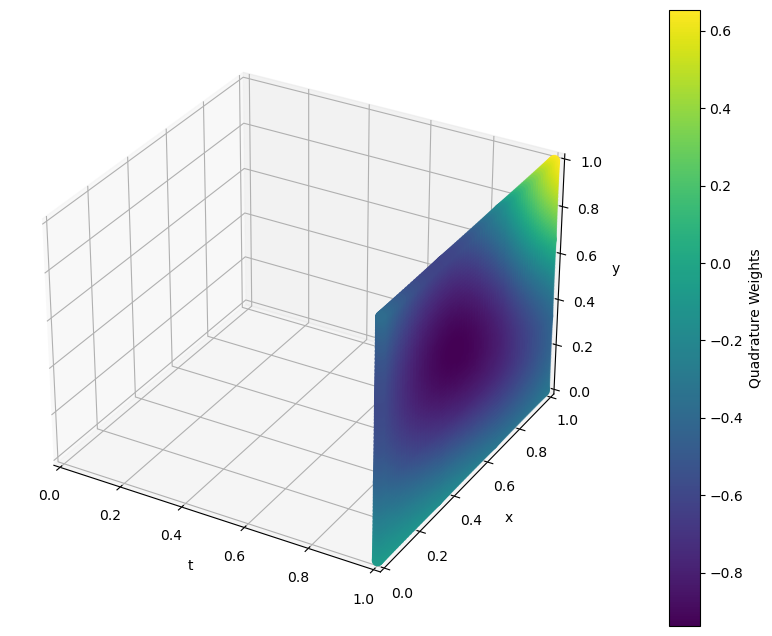

In [16]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with weights determining the color
sc = ax.scatter(x[:,0], x[:,1], x[:,2],
            c=u_exact[0], cmap='viridis', s=50)

# Add colorbar and labels
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Quadrature Weights')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('y')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)

# plt.savefig("ndquadrature.svg", bbox_inches='tight')#, transparent=True)

plt.show()

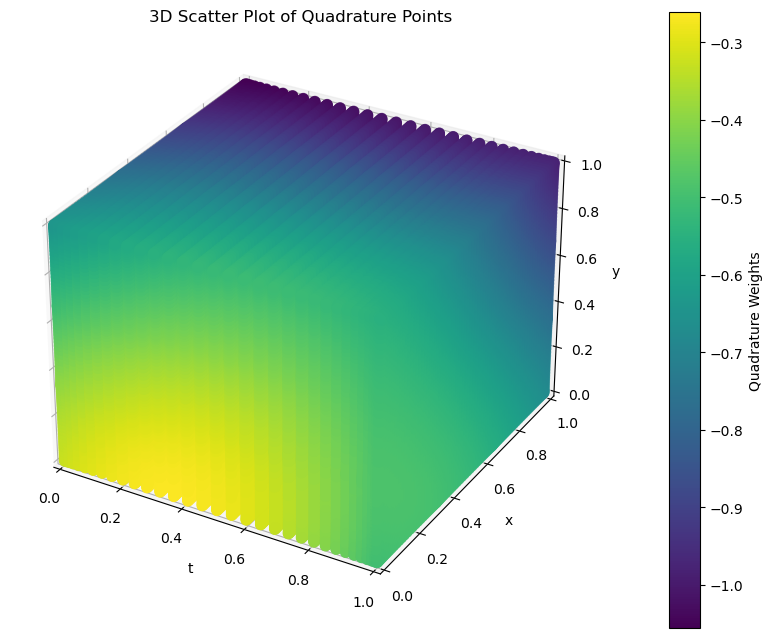

In [32]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with weights determining the color
sc = ax.scatter(x[:,0], x[:,1], x[:,2],
            c=u_hat[0], cmap='viridis', s=50)

# Add colorbar and labels
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Quadrature Weights')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('y')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)

# plt.savefig("ndquadrature.svg", bbox_inches='tight')#, transparent=True)

plt.show()

In [180]:
N_samples = 100

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low


tau = np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
# tau = np.array([1])


L2_scaled_avg = np.zeros((len(modeldict),len(tau)))
yerr = np.zeros((len(modeldict),2,len(tau)))

size_title = 20
size_ticklabels = 15
size_axeslabels = 20

quadrature = GaussLegendreQuadrature(n_elements=[3,3,3], Q=[12,12,12])
x = quadrature.xi
w = quadrature.w

linestyles=['-','-','--','--','--','--','--','--','--','--']
colors = ['black','C0','C2','C3','C4']
    
for i in range(len(tau)):
    print(tau[i])
    dataset = ManufacturedSolutionsSet(N_samples=N_samples, variables=['t','x','x'], l_min=[tau[i],1,1], l_max=[tau[i],1,1], device=device)
    theta = dataset.theta
    f = dataset.f
    etat = dataset.etat
    etab = dataset.etab
    gl = dataset.gl
    gr = dataset.gr
    u = dataset.u
    u0 = dataset.u0
    m=0
    for model in modeldict:
        print(str(model))
        modeldict[str(model)].hparams['assembly_batch_size'] = N_samples
        print(f"Memory allocated: {torch.cuda.memory_allocated(device) / 1024 ** 2:.2f} MB")
        print(f"Memory reserved: {torch.cuda.memory_reserved(device) / 1024 ** 2:.2f} MB")
        u_exact = discretize_functions(u, x, dtype=modeldict[str(model)].hparams['dtype'], device=device)
        print(f"Memory allocated: {torch.cuda.memory_allocated(device) / 1024 ** 2:.2f} MB")
        print(f"Memory reserved: {torch.cuda.memory_reserved(device) / 1024 ** 2:.2f} MB")
        u_hat = modeldict[str(model)].simforward(theta, f, etab, etat, gl, gr, u0, x, u)
        print(f"Memory allocated: {torch.cuda.memory_allocated(device) / 1024 ** 2:.2f} MB")
        print(f"Memory reserved: {torch.cuda.memory_reserved(device) / 1024 ** 2:.2f} MB")
        L2_scaled_array = weightedrelativeL2_set(w, u_hat, u_exact)
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])
        m+=1

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
plots.append(ax.axvspan(0.5,1, color='black', alpha=0.1, label='Training data range'))
m=0
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'Time scale $\tau/T$', fontsize=size_axeslabels)
ax.set_ylabel(r'Rel. L2 error $\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_yscale('log')
ax.set_xlim(0, 1.05)
ax.grid()
# ax.set_title('FNO', fontsize=size_title)
for model in modeldict:
    plots.append(ax.errorbar(tau, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))
    m+=1
plt.legend(fontsize=10, ncols=1)
# legend1 = ax.legend(handles=plots[0:2],fontsize=10, ncols=1, loc='lower left')
# plt.gca().add_artist(legend1)
# legend2 = ax.legend(handles=plots[2:],fontsize=10, ncols=2, loc='upper right')
# plt.gca().add_artist(legend2)

# plt.savefig("FNO.pdf", bbox_inches='tight')#, transparent=True)
plt.savefig("timescales.svg", bbox_inches='tight')#, transparent=True)
plt.savefig("timescales.pdf", bbox_inches='tight')#, transparent=True)
plt.show()

0.05
Projection
Memory allocated: 1494.15 MB
Memory reserved: 1982.00 MB
Memory allocated: 1494.15 MB
Memory reserved: 1982.00 MB
0
[[ 0.29714835  0.29595125  0.29908989 ...  0.27522226  0.2041999
   0.15449602]
 [ 0.57055563  0.57922604  0.57970209 ... -0.00516788  0.01901144
   0.03567799]
 [ 0.02927382  0.03224573  0.03105939 ... -0.36555752 -0.29662192
  -0.24753844]
 ...
 [ 0.41593814  0.41286608  0.41313705 ...  0.50738344  0.50676257
   0.50638943]
 [ 1.10392895  1.10621003  1.1063359  ...  0.95181036  0.93836336
   0.92962295]
 [ 0.85366917  0.8767341   0.90735847 ... -0.22537216 -0.26341613
  -0.28180402]]
[[ 0.3700982   0.37003765  0.36993048 ...  0.47955775  0.4799003
   0.48009151]
 [ 0.25916821  0.25932649  0.25960624 ... -0.61941946 -0.61982512
  -0.62004864]
 [-0.17029759 -0.17020339 -0.17003606 ... -0.36784992 -0.36750886
  -0.36731884]
 ...
 [ 0.51277786  0.51276052  0.51272982 ...  0.5875122   0.58749568
   0.58748627]
 [ 1.27673757  1.27683353  1.27700245 ...  0.4562

ValueError: operands could not be broadcast together with shapes (100,1728) (100,323433) 